In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
import numpy as np
from skimage.io import imread, imsave
from matplotlib import pyplot as plt

In [3]:
from corrector import Dataset, PredictionsCorrector

In [4]:
import dask.array as da

In [4]:
imfiles = np.load('/data/IASEM/conradrw/data/images224_fpaths_qsf.npy')
#imfiles_qsf = np.load('/data/IASEM/conradrw/data/images224_fpaths_qsf_nn_filtered.npy')
#imfiles = np.setdiff1d(imfiles, imfiles_qsf)

In [5]:
len(imfiles)

995283

## Manual Labeling

In [11]:
#make a dataset class and assume that all images are good for now
dataset = Dataset(imfiles, labels=np.array(['good'] * len(imfiles)), num_images=100, eval_label=None)

In [13]:
#manual label images by changing default "good" to "bad"
#in the dropdown that appears under the image
classes = ['good', 'bad']
pc = PredictionsCorrector(dataset, classes, batch_size=50, rows=5) #50 images in 5 rows implies 10 columns

'No images to show :)'

In [8]:
#np.where(np.array(pc.corrected_labels()) == 'bad')[0].shape, np.where(np.array(pc.corrected_labels()) == 'good')[0].shape

In [9]:
#np.save('/data/IASEM/conradrw/data/images224_fpaths_qsf_rf_gt.npy', np.array(pc.corrected_labels()))

## Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, average_precision_score, plot_precision_recall_curve, accuracy_score

In [14]:
features = np.load('/data/IASEM/conradrw/data/images224_fpaths_qsf_rf_features.npy')
gt_labels = np.load('/data/IASEM/conradrw/data/images224_fpaths_qsf_rf_gt.npy')

In [16]:
good_indices = np.where(gt_labels == 'good')[0]
bad_indices = np.where(gt_labels == 'bad')[0]
labeled_indices = np.concatenate([good_indices, bad_indices], axis=0)
unlabeled_indices = np.setdiff1d(range(len(features)), labeled_indices)

In [17]:
good_indices.shape, bad_indices.shape, labeled_indices.shape, unlabeled_indices.shape

((7621,), (6174,), (13795,), (981488,))

In [18]:
gt_labels.shape, imfiles.shape

((995283,), (995283,))

In [19]:
from sklearn.model_selection import train_test_split
np.random.seed(1227)
trn_indices, val_indices = train_test_split(labeled_indices, test_size=0.2)

In [23]:
trn_imfiles = imfiles[trn_indices]
#trn_features = features[labeled_indices]
#trn_labels = np.zeros((len(imfiles), ))
#trn_labels[good_indices] = 1
#trn_labels = trn_labels[labeled_indices]
trn_features = features[trn_indices]
labels = np.zeros((len(features), ))
labels[good_indices] = 1
trn_labels = labels[trn_indices]
val_features = features[val_indices]
val_labels = labels[val_indices]

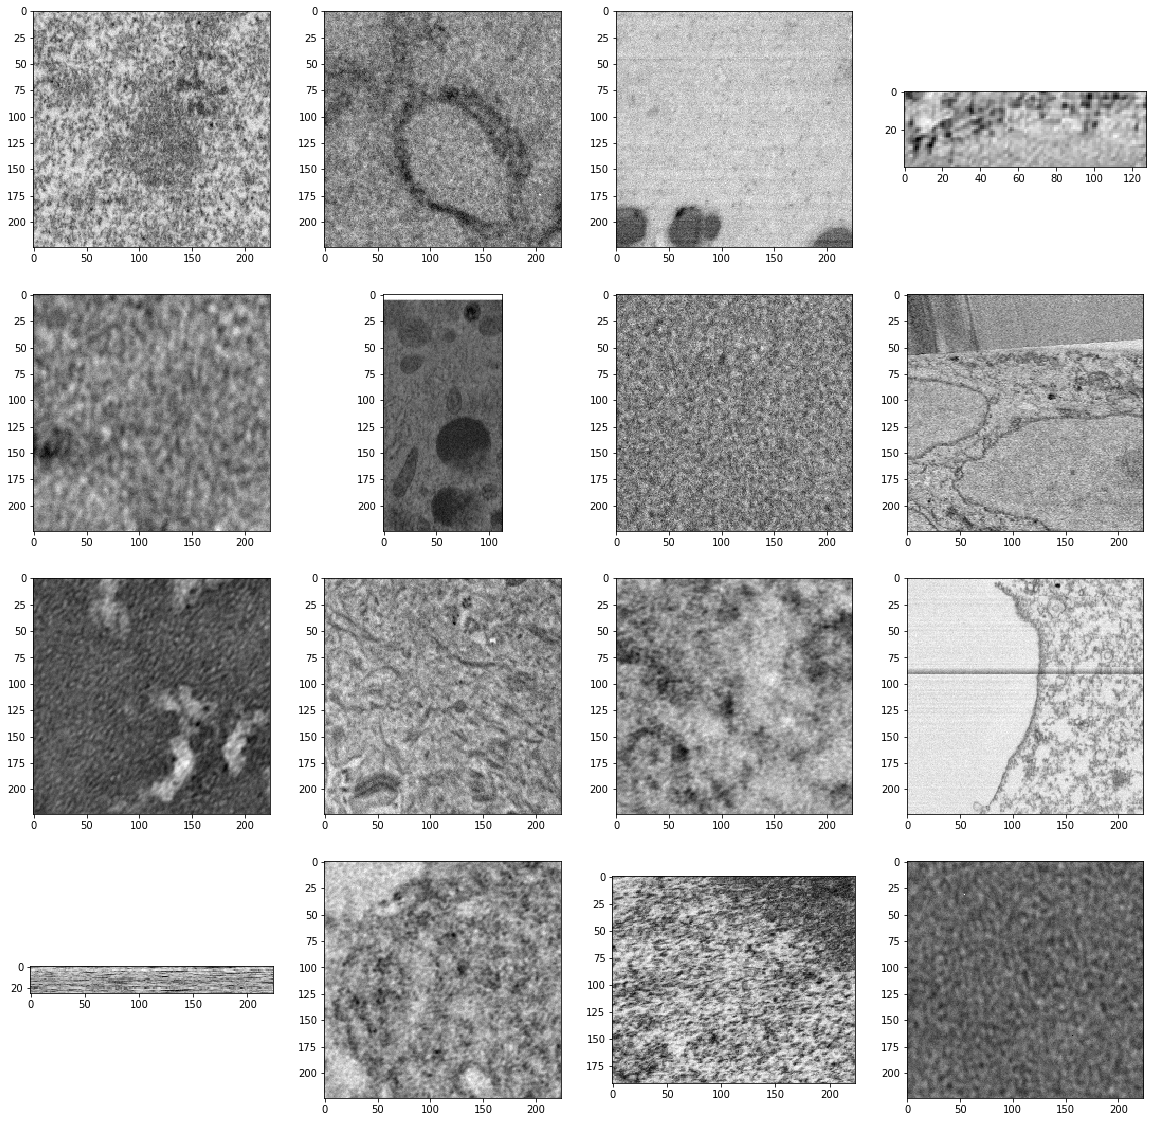

In [26]:
f, ax = plt.subplots(4, 4, figsize=(20, 20), squeeze=False)

for y in range(4):
    for x in range(4):
        idx = np.random.choice(np.where(trn_labels == 0)[0])
        f1 = trn_imfiles[idx]
        #print(f1, idx)
        ax[y, x].imshow(imread(f1), cmap='gray')
        
#plt.savefig('./bad1.png')

In [78]:
#rf = ExtraTreesClassifier(max_depth=16, class_weight='balanced', min_samples_split=4)
rf = RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced',  min_samples_split=8)
rf = rf.fit(trn_features, trn_labels)

<BarContainer object of 4 artists>

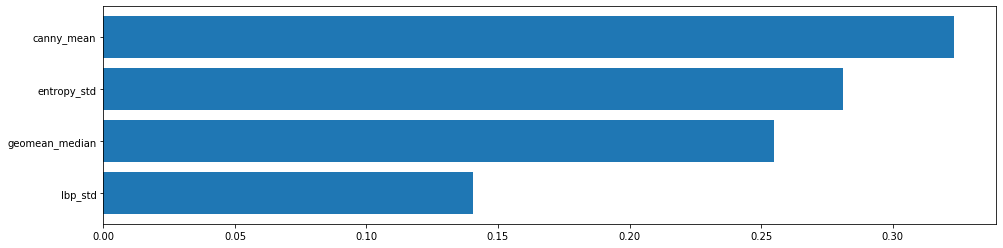

In [79]:
feature_names = {0: 'lbp_std', 1: 'geomean_median', 2: 'entropy_std', 3: 'canny_mean'}
plt.figure(figsize=(16, 4))
plt.barh([feature_names[f] for f in np.argsort(rf.feature_importances_)], np.sort(rf.feature_importances_))

In [80]:
trn_predictions = rf.predict_proba(trn_features)[:, 1] #> 0.5
print(confusion_matrix(trn_labels, trn_predictions > 0.5))
print(average_precision_score(trn_labels, trn_predictions))
print(accuracy_score(trn_labels, trn_predictions > 0.5))

[[3883 1041]
 [ 619 5493]]
0.9204734776297278
0.849583182312432


[[ 939  311]
 [ 196 1313]]
0.8950214296632961
0.8162377673069953


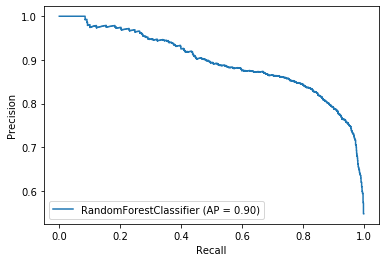

In [38]:
val_predictions_rf = rf.predict_proba(val_features)[:, 1]
print(confusion_matrix(val_labels, val_predictions > 0.5))
print(average_precision_score(val_labels, val_predictions))
print(accuracy_score(val_labels, val_predictions > 0.5))
plot_precision_recall_curve(rf, val_features, val_labels)

In [39]:
tst_features = features[unlabeled_indices]
tst_predictions = rf.predict_proba(tst_features)[:, 1]

In [40]:
tst_predictions = np.logical_and(tst_predictions > 0.5, tst_predictions <= 1)

In [18]:
tst_predictions.shape, tst_predictions.sum()

((981488,), 666963)

In [19]:
#np.save('/data/IASEM/conradrw/data/images224_fpaths_qsf_rf_predictions.npy', tst)

## Prediction Correction

In [10]:
label_names = []
for pl in range(len(imfiles)):#tst_predictions:
    #if pl == 1:
    label_names.append('resin')
    #else:
    #    label_names.append('bad')
        
label_names = np.array(label_names)

In [12]:
#len(label_names), len(unlabeled_indices), len(imfiles)

In [13]:
#dataset = Dataset(imfiles[unlabeled_indices], labels=label_names, num_images=200, eval_label=None)
dataset = Dataset(imfiles, labels=label_names, num_images=500, eval_label=None)

In [14]:
classes = ['resin', 'cytoplasm', 'nucleus', 'artifacts', 'nonsense', 'false negatives', 'low_contrast']
pc = PredictionsCorrector(dataset, classes, 50, 5)

'No images to show :)'

In [15]:
print(f'Corrected fraction: {len(pc.corrections.values()) / dataset.num_images}')

Corrected fraction: 0.668


In [19]:
np.save('./pred_bad_fnames500.npy', dataset.fnames)

In [23]:
pc.corrections

{0: 'cytoplasm',
 3: 'cytoplasm',
 4: 'cytoplasm',
 5: 'nonsense',
 6: 'low_contrast',
 9: 'nonsense',
 18: 'nonsense',
 17: 'nonsense',
 16: 'low_contrast',
 15: 'nonsense',
 14: 'nonsense',
 13: 'cytoplasm',
 12: 'nucleus',
 10: 'nucleus',
 11: 'cytoplasm',
 20: 'low_contrast',
 22: 'cytoplasm',
 23: 'cytoplasm',
 24: 'low_contrast',
 25: 'artifacts',
 28: 'cytoplasm',
 38: 'low_contrast',
 37: 'cytoplasm',
 36: 'nucleus',
 34: 'nonsense',
 33: 'nonsense',
 32: 'nonsense',
 31: 'nonsense',
 41: 'artifacts',
 43: 'nucleus',
 44: 'nucleus',
 45: 'cytoplasm',
 46: 'nonsense',
 47: 'nonsense',
 49: 'nucleus',
 99: 'nonsense',
 98: 'nucleus',
 97: 'nonsense',
 96: 'nonsense',
 95: 'resin',
 94: 'nucleus',
 91: 'nonsense',
 90: 'nonsense',
 81: 'cytoplasm',
 82: 'low_contrast',
 83: 'nonsense',
 85: 'nucleus',
 86: 'nonsense',
 87: 'nonsense',
 88: 'nonsense',
 89: 'nonsense',
 71: 'low_contrast',
 60: 'cytoplasm',
 61: 'artifacts',
 62: 'resin',
 63: 'nonsense',
 64: 'artifacts',
 65: 'no

In [ ]:
np.save('./pred_bad_fnames500.npy', dataset.fnames)

In [25]:
unlabeled_indices = np.arange(len(imfiles))

In [27]:
gt_indices = unlabeled_indices[dataset.label_indices[dataset.permutation]]
gt_indices_labels = dataset.labels
gt_indices_labels[list(pc.corrections.keys())] = np.array(list(pc.corrections.values()))

In [30]:
np.save('./pred_bad_reasons500.npy', gt_indices_labels)

In [50]:
np.unique(gt_indices_labels)

array(['artif', 'cytop', 'false', 'low_c', 'nonse', 'nucle', 'resin'],
      dtype='<U5')

In [53]:
from PIL import Image

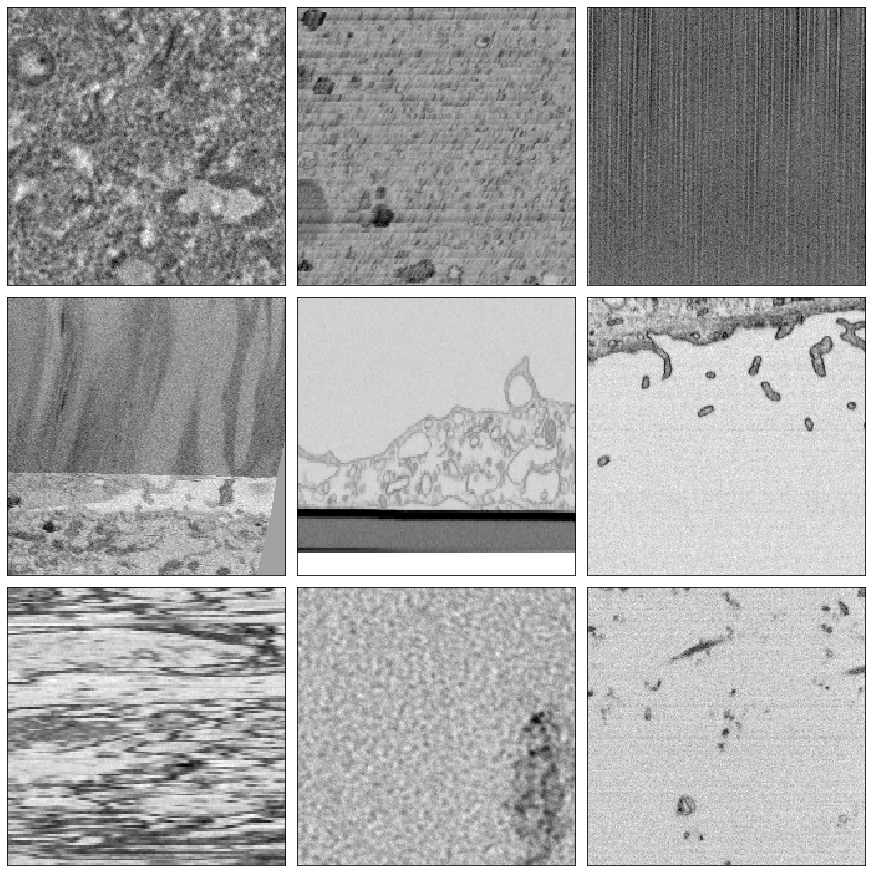

In [61]:
btype = 'resin'
indices = np.where(gt_indices_labels == btype)[0]

gs_kw = {'wspace': 5, 'hspace': 5}
f, ax = plt.subplots(ncols=3, nrows=3, constrained_layout=True,
                             gridspec_kw=gs_kw, figsize=(12, 12))

for y in range(3):
    for x in range(3):
        idx = np.random.choice(indices)
        f1 = dataset.fnames[idx]
        #print(f1, idx)
        ax[y, x].imshow(Image.open(f1).resize((224, 224), 0), cmap='gray')
        ax[y, x].tick_params(
                axis='both',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                right=False,
                labelbottom=False,
                labelleft=False)
        
plt.savefig(f'./pred_bad_{btype}.png', dpi=300)

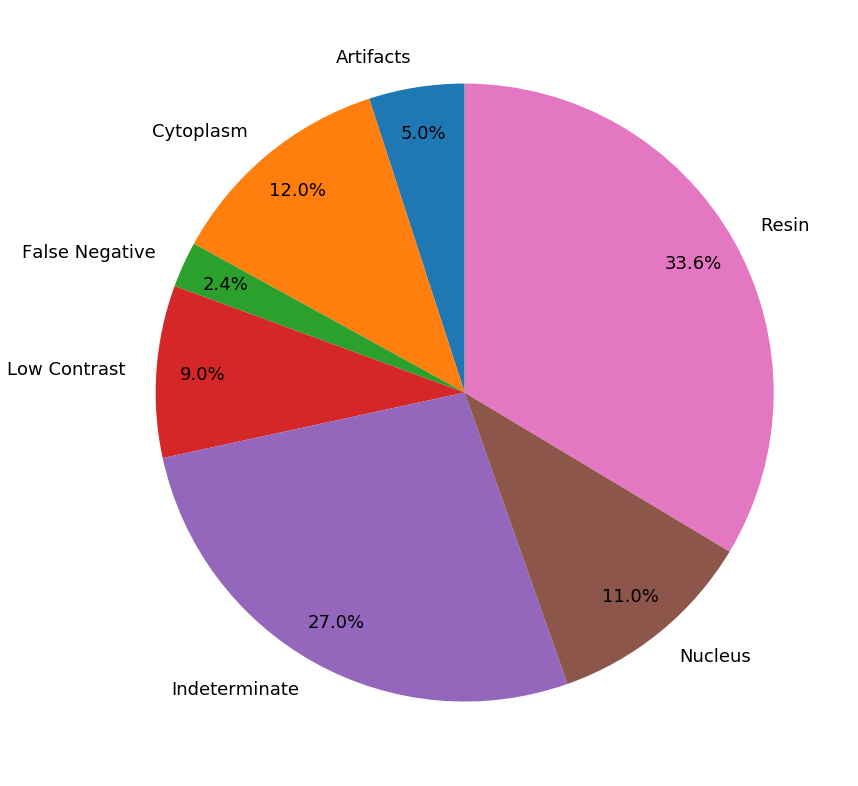

In [62]:
labels = ['Artifacts', 'Cytoplasm', 'False Negative', 'Low Contrast', 'Indeterminate', 'Nucleus', 'Resin']
_, sizes = np.unique(gt_indices_labels, return_counts=True)

#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
#explsion
#explode = len(labels) * (0.05,)

plt.figure(figsize=(12, 12))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, textprops={'fontsize': 18})
#draw circle
#centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
#fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig('./pred_bad_pie_chart.png', dpi=300)

In [568]:
gt_indices = unlabeled_indices[dataset.label_indices[dataset.permutation]]
gt_indices_labels = dataset.labels
gt_indices_labels[list(pc.corrections.keys())] = np.array(list(pc.corrections.values()))

In [569]:
gt_labels[gt_indices] = gt_indices_labels
np.save('/data/IASEM/conradrw/data/images224_fpaths_qsf_rf_gt.npy', gt_labels)

## Accept predictions

In [20]:
features.shape

(995283, 4)

In [21]:
predictions = rf.predict_proba(features)[:, 1]
predictions = np.logical_and(predictions > 0.5, predictions <= 1)
accepted_imfiles = imfiles[predictions]

In [22]:
len(accepted_imfiles)

675485

In [23]:
#np.save('/data/IASEM/conradrw/data/images224_fpaths_qsf_rf_filtered.npy', accepted_imfiles)

## Neural Net

In [41]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

from albumentations import (
    Compose, PadIfNeeded, Normalize, HorizontalFlip, VerticalFlip, RandomBrightnessContrast, 
    CropNonEmptyMaskIfExists, GaussNoise, RandomBrightnessContrast, RandomResizedCrop, Rotate, RandomCrop,
    GaussianBlur, CenterCrop, RandomGamma, ElasticTransform
)

from albumentations.pytorch import ToTensorV2
from torchvision.models import resnet34

from torch.optim import AdamW, SGD
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [42]:
normalize = Normalize()

crop_size = 224
tfs = Compose([
    PadIfNeeded(min_height=crop_size, min_width=crop_size),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    GaussNoise(var_limit=(40, 100.0), p=0.5),
    GaussianBlur(blur_limit=5, p=0.5),
    HorizontalFlip(),
    VerticalFlip(),
    normalize,
    ToTensorV2()
])

eval_tfs = Compose([
    PadIfNeeded(min_height=crop_size, min_width=crop_size),
    normalize,
    ToTensorV2()
])

In [43]:
imfiles = np.load('/data/IASEM/conradrw/data/images224_fpaths_qsf.npy')
gt_labels = np.load('/data/IASEM/conradrw/data/images224_fpaths_qsf_rf_gt.npy')

good_indices = np.where(gt_labels == 'good')[0]
bad_indices = np.where(gt_labels == 'bad')[0]
labeled_indices = np.concatenate([good_indices, bad_indices], axis=0)
unlabeled_indices = np.setdiff1d(range(len(features)), labeled_indices)

In [44]:
from sklearn.model_selection import train_test_split
np.random.seed(1227)
trn_indices, val_indices = train_test_split(labeled_indices, test_size=0.2)
np.random.seed(None)

In [45]:
labels = np.zeros((len(imfiles), ))
labels[good_indices] = 1
trn_imfiles = imfiles[trn_indices]
trn_labels = labels[trn_indices]
val_imfiles = imfiles[val_indices]
val_labels = labels[val_indices]
tst_imfiles = imfiles[unlabeled_indices]
tst_labels = labels[unlabeled_indices]

In [46]:
import cv2

class SimpleDataset(Dataset):
    def __init__(self, imfiles, labels, tfs=None):
        super(SimpleDataset, self).__init__()
        self.imfiles = imfiles
        self.labels = labels
        self.tfs = tfs
        
    def __len__(self):
        return len(self.imfiles)
    
    def __getitem__(self, idx):
        #load the image
        image = imread(self.imfiles[idx])
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        #load the label
        label = self.labels[idx]
        
        #apply transforms
        if self.tfs is not None:
            image = self.tfs(image=image)['image']
            
        return {'image': image, 'label': label}

In [47]:
trn_data = SimpleDataset(trn_imfiles, trn_labels, tfs)
val_data = SimpleDataset(val_imfiles, val_labels, eval_tfs)
tst_data = SimpleDataset(tst_imfiles, tst_labels, eval_tfs)

0.0


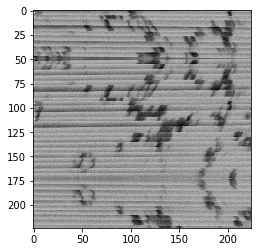

In [48]:
index = np.random.randint(0, len(val_data))
data = val_data[index]
print(data['label'])
plt.imshow(data['image'][0], cmap='gray')

In [49]:
bsz = 64
train = DataLoader(trn_data, batch_size=bsz, shuffle=True, pin_memory=True, drop_last=True, num_workers=4)
valid = DataLoader(val_data, batch_size=bsz, shuffle=False, pin_memory=True, num_workers=4)
test = DataLoader(tst_data, batch_size=128, shuffle=False, pin_memory=True, num_workers=4)

In [92]:
model = resnet34(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(in_features=512, out_features=1)

state = torch.load('/data/IASEM/conradrw/data/nn_filtering.pth', map_location='cpu')
model.load_state_dict(state)

model = model.cuda()

In [93]:
#freeze all backbone layers to start and only open
#them when specified
#for param in model.parameters():
#    param.requires_grad = False

finetune_layer = 'layer4'
backbone_groups = [mod[1] for mod in model.named_children()]
if finetune_layer != 'none':
    layer_index = {'all': 0, 'layer1': 4, 'layer2': 5, 'layer3': 6, 'layer4': 7}
    start_layer = layer_index[finetune_layer]

    #always finetune from the start layer to the last layer in the resnet
    for group in backbone_groups[start_layer:]:
        for param in group.parameters():
            param.requires_grad = True
                
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Using model with {params} trainable parameters!')

Using model with 13114881 trainable parameters!


In [94]:
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=1e-4)

In [95]:
cudnn.benchmark = True

In [96]:
def accuracy(output, labels):
    #squeeze both
    output = output.squeeze()
    labels = labels.squeeze() > 0
    
    #sigmoid output
    output = nn.Sigmoid()(output) > 0.5
    
    #measure correct
    correct = torch.sum(output == labels).float()
    return (correct / len(labels)).item()

In [115]:
for epoch in range(2):
    rl = 0
    ra = 0
    for data in tqdm(train):
        #load data onto gpu
        images = data['image'].cuda(non_blocking=True)
        labels = data['label'].cuda(non_blocking=True)

        #zero grad
        optimizer.zero_grad()

        #forward
        output = model.train()(images)
        loss = criterion(output, labels.unsqueeze(1))

        #backward
        loss.backward()

        #step
        optimizer.step()

        rl += loss.item()
        ra += accuracy(output, labels)

    print(f'Epoch {epoch + 1}, Loss {rl / len(train)}, Accuracy {ra / len(train)}')
    
    rl = 0
    ra = 0
    for data in tqdm(valid):
        #load data onto gpu
        images = data['image'].cuda(non_blocking=True)
        labels = data['label'].cuda(non_blocking=True)
        
        #forward
        output = model.eval()(images)
        loss = criterion(output, labels.unsqueeze(1))
        rl += loss.item()
        ra += accuracy(output, labels)

    print(f'Val Loss {rl / len(valid)}, Accuracy {ra / len(valid)}')


Epoch 1, Loss 0.20594385409553864, Accuracy 0.9151526162790697



Val Loss 0.271205025087477, Accuracy 0.8923498392105103



Epoch 2, Loss 0.1990143526922488, Accuracy 0.9171511627906976



Val Loss 0.267121465674837, Accuracy 0.8930600664832375


In [99]:
predictions = []
for data in tqdm(valid):
    #load data onto gpu
    images = data['image'].cuda(non_blocking=True)

    #forward
    output = model.eval()(images)
    pred = nn.Sigmoid()(output)
    predictions.append(pred.detach().cpu().numpy())

In [100]:
val_predictions = np.concatenate(predictions, axis=0)

In [ ]:
#np.save('./val_predictions.npy', val_predictions)

In [101]:
len(val_labels)

2759

In [102]:
accuracy_score(val_labels, val_predictions > 0.5)

0.8952519028633563

In [103]:
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score

In [104]:
import seaborn as sns

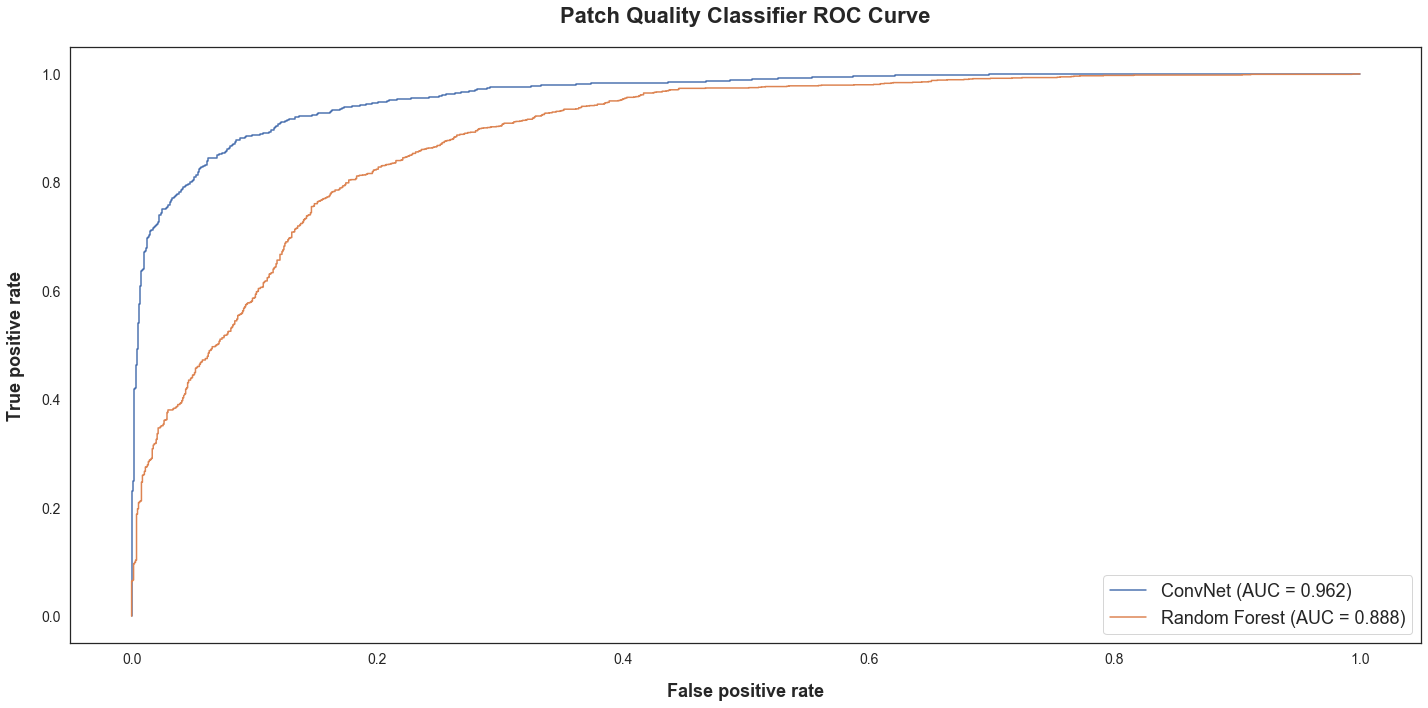

In [117]:
fpr_nn, tpr_nn, _ = roc_curve(val_labels, val_predictions)
fpr_rf, tpr_rf, _ = roc_curve(val_labels, val_predictions_rf)

sns.set(context="notebook", style="white")
plt.figure(figsize=(20, 10))
plt.plot(fpr_nn, tpr_nn, label=f'ConvNet (AUC = {roc_auc_score(val_labels, val_predictions):.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(val_labels, val_predictions_rf):.3f})')
plt.xlabel('False positive rate', labelpad=16, fontsize=18, fontweight="bold")
plt.xticks(fontsize=14)
plt.ylabel('True positive rate', labelpad=16, fontsize=18, fontweight="bold")
plt.yticks(fontsize=14)
plt.title('Patch Quality Classifier ROC Curve', fontdict={'fontsize': 22, 'fontweight': "bold"}, pad=24)
plt.tight_layout()
plt.legend(loc='best', fontsize=18)
plt.savefig('./patch_classifier_roc.png', dpi=300)

In [86]:
tst_predictions.shape, tst_imfiles.shape

((981488, 1), (981488,))

In [90]:
np.save('/data/IASEM/conradrw/data/images224_fpaths_qsf_nn_filtered_unlabeled.npy', tst_predictions)

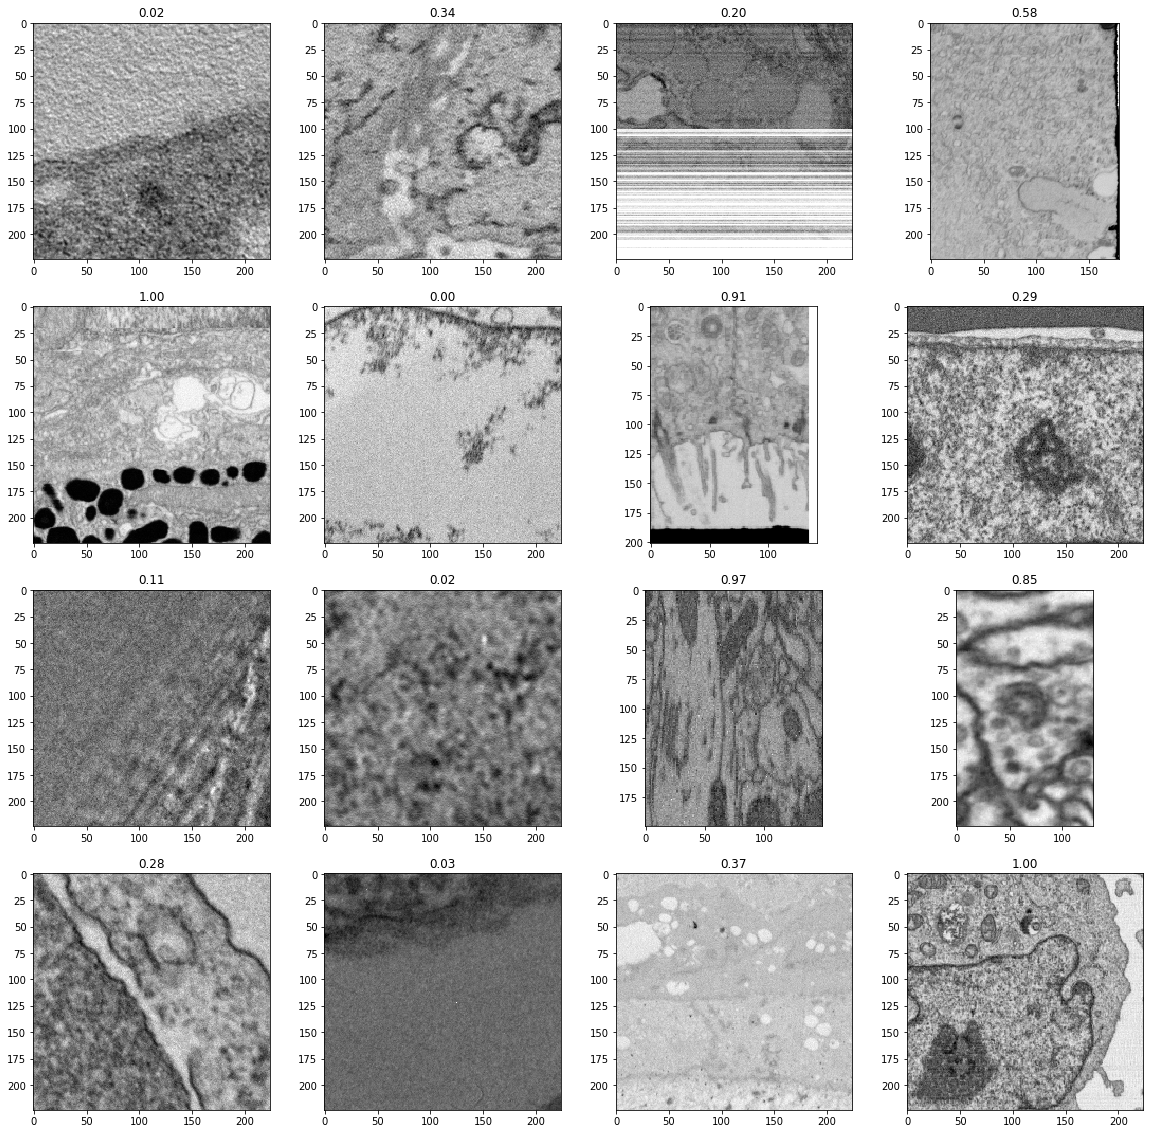

In [95]:
f, ax = plt.subplots(4, 4, figsize=(20, 20))

for y in range(4):
    for x in range(4):
        index = np.random.randint(0, len(tst_predictions))
        image = imread(tst_imfiles[index])
        ax[y, x].imshow(image, cmap='gray')
        ax[y, x].set_title(f'{tst_predictions[index, 0]:.2f}')

In [103]:
all_predictions = np.zeros((len(imfiles),)).astype(np.uint8)
all_predictions[trn_indices] = trn_labels.astype(np.uint8)
all_predictions[val_indices] = val_labels.astype(np.uint8)
all_predictions[unlabeled_indices] = (tst_predictions[:, 0] > 0.5).astype(np.uint8)

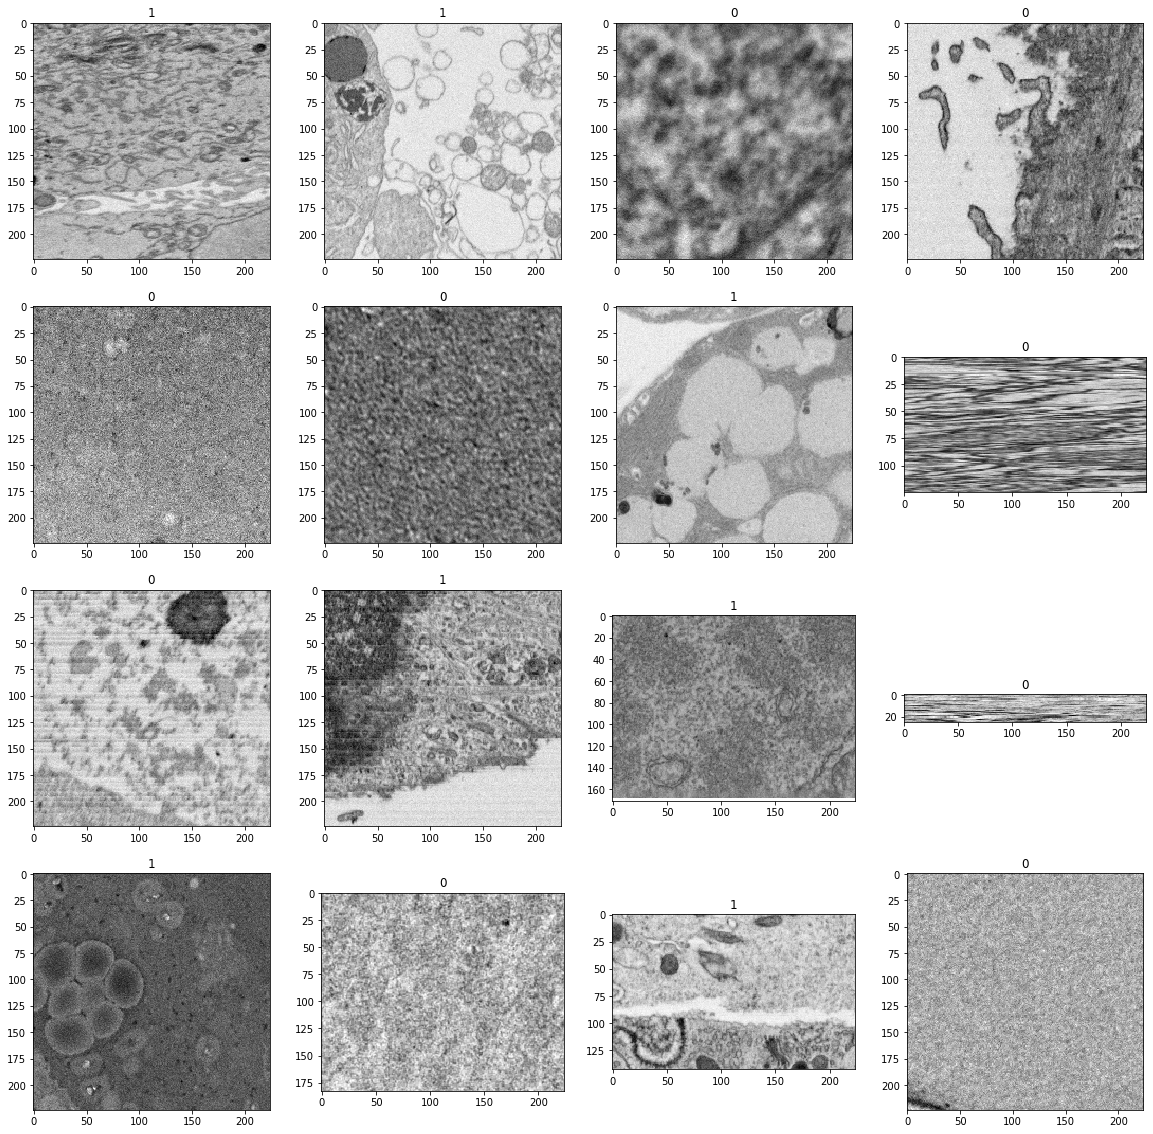

In [111]:
f, ax = plt.subplots(4, 4, figsize=(20, 20))

for y in range(4):
    for x in range(4):
        index = np.random.randint(0, len(all_predictions))
        image = imread(imfiles[index])
        ax[y, x].imshow(image, cmap='gray')
        ax[y, x].set_title(f'{all_predictions[index]}')

In [112]:
np.save('/data/IASEM/conradrw/data/images224_fpaths_qsf_nn_filtered.npy', all_predictions)

In [107]:
#torch.save(model.state_dict(), '/data/IASEM/conradrw/data/nn_filtering.pth')

In [ ]:
1 + 1